In [ ]:
!pip install plot_model

In [164]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D,BatchNormalization
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')


In [165]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [166]:
IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES = 10
TEST_SIZE = 0.2
RANDOM_STATE = 2018
#Model
NO_EPOCHS = 15
BATCH_SIZE = 128

IS_LOCAL = False

import os

if(IS_LOCAL):
    PATH="../content/drive/MyDrive/Colab Notebooks/Dataset/fashion-mnist/"
else:
    PATH="../content/drive/MyDrive/Colab Notebooks/Dataset/fashion-mnist/"
print(os.listdir(PATH))

['fashion-mnist_test.csv', 'fashion-mnist_train.csv', 't10k-labels-idx1-ubyte', 'train-labels-idx1-ubyte', 't10k-images-idx3-ubyte', '.ipynb_checkpoints', 'train-images-idx3-ubyte']


In [167]:
train_file = PATH+"fashion-mnist_train.csv"
test_file  = PATH+"fashion-mnist_test.csv"

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

In [168]:
print("Fashion MNIST train -  rows:",train_data.shape[0]," columns:", train_data.shape[1])
print("Fashion MNIST test -  rows:",test_data.shape[0]," columns:", test_data.shape[1])

Fashion MNIST train -  rows: 60000  columns: 785
Fashion MNIST test -  rows: 10000  columns: 785


In [169]:
train_data.head(10)
test_data.head(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,255,215,...,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,204,235,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,44,105,44,10,0,0,0,0,0,0,0,0,0,0,0,34,68,34,0,0,0,0,0,0,0,0,0,34,136,102,105,98,74,64,...,129,122,125,139,132,132,10,0,0,0,0,0,0,0,0,0,0,0,0,23,57,105,108,115,125,125,122,122,125,119,105,64,30,0,0,0,0,0,0,0
6,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,6,0,0,0,0,0,0,0,1,0,0,0,108,25,0,0,0,132,54,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,11,61,102,...,146,196,197,136,215,42,0,3,0,0,0,0,0,0,0,0,0,0,1,0,82,172,159,150,140,142,164,160,153,202,174,136,155,31,0,1,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,75,192,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,92,66,0,0,0,0,81,91,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,75,111,118,...,121,117,104,110,69,0,0,1,0,0,0,0,0,0,0,0,0,0,0,49,63,52,55,57,57,55,53,53,55,61,57,70,28,0,2,0,0,0,0,0


In [170]:
# Select all columns but the first
features = train_data[train_data.columns[1:]]
features.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,227,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,136,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,0,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [171]:
labels = train_data['label']
labels.describe(include='all')

count    60000.000000
mean         4.500000
std          2.872305
min          0.000000
25%          2.000000
50%          4.500000
75%          7.000000
max          9.000000
Name: label, dtype: float64

In [172]:
# Create a dictionary for each type of label 
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

def get_classes_distribution(data):
    # Get the count for each label
    label_counts = data["label"].value_counts()

    # Get total number of samples
    total_samples = len(data)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))

get_classes_distribution(train_data)

Ankle Boot          :   6000 or 10.0%
Bag                 :   6000 or 10.0%
Sneaker             :   6000 or 10.0%
Shirt               :   6000 or 10.0%
Sandal              :   6000 or 10.0%
Coat                :   6000 or 10.0%
Dress               :   6000 or 10.0%
Pullover            :   6000 or 10.0%
Trouser             :   6000 or 10.0%
T-shirt/top         :   6000 or 10.0%


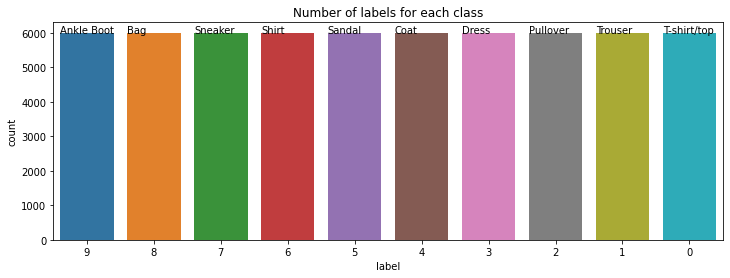

In [173]:
def plot_label_per_class(data):
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(data.label, order = data["label"].value_counts().index)
    g.set_title("Number of labels for each class")

    for p, label in zip(g.patches, data["label"].value_counts().index):
        g.annotate(labels[label], (p.get_x(), p.get_height()+0.1))
    plt.show()  
    
plot_label_per_class(train_data)

In [174]:
get_classes_distribution(test_data)

Sneaker             :   1000 or 10.0%
Shirt               :   1000 or 10.0%
Sandal              :   1000 or 10.0%
Coat                :   1000 or 10.0%
Dress               :   1000 or 10.0%
Pullover            :   1000 or 10.0%
Ankle Boot          :   1000 or 10.0%
Trouser             :   1000 or 10.0%
Bag                 :   1000 or 10.0%
T-shirt/top         :   1000 or 10.0%


In [175]:
def sample_images_data(data):
    # An empty list to collect some samples
    sample_images = []
    sample_labels = []

    # Iterate over the keys of the labels dictionary defined in the above cell
    for k in labels.keys():
        # Get four samples for each category
        samples = data[data["label"] == k].head(4)
        # Append the samples to the samples list
        for j, s in enumerate(samples.values):
            # First column contain labels, hence index should start from 1
            img = np.array(samples.iloc[j, 1:]).reshape(IMG_ROWS,IMG_COLS)
            sample_images.append(img)
            sample_labels.append(samples.iloc[j, 0])

    print("Total number of sample images to plot: ", len(sample_images))
    return sample_images, sample_labels

train_sample_images, train_sample_labels = sample_images_data(train_data)

Total number of sample images to plot:  40


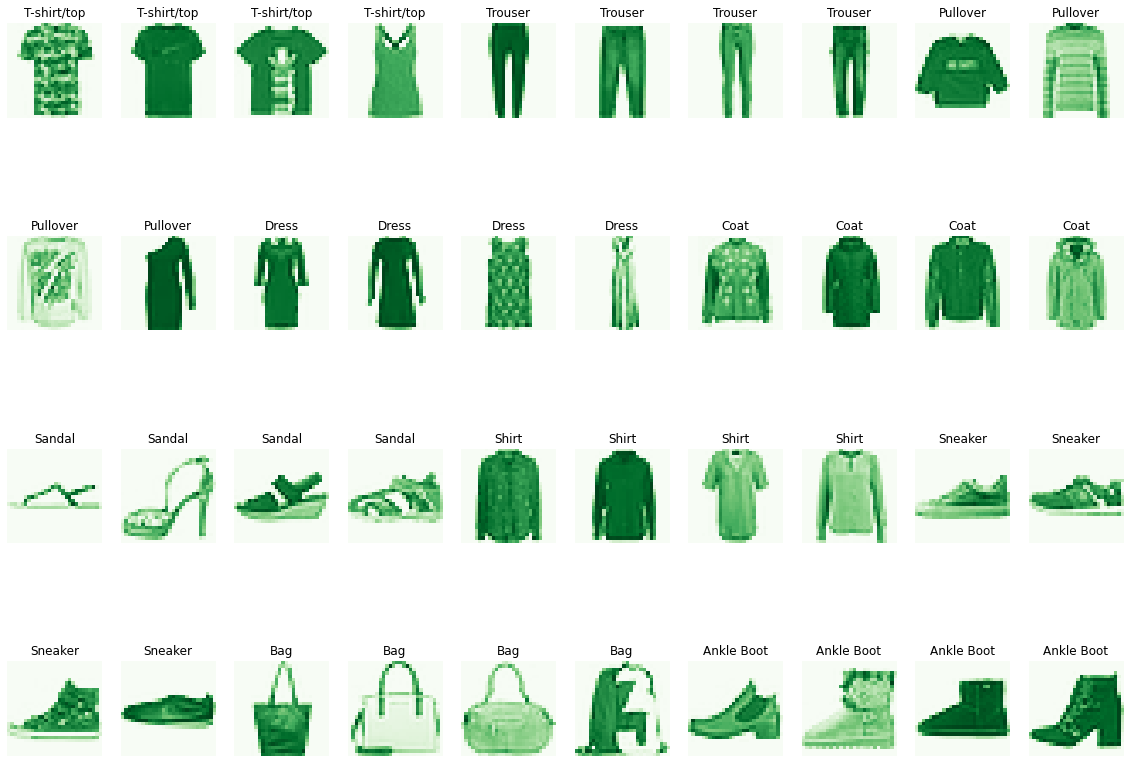

In [176]:
def plot_sample_images(data_sample_images,data_sample_labels,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(4,10, figsize=(20,15))

    for i, img in enumerate(data_sample_images):
        ax[i//10, i%10].imshow(img, cmap=cmap)
        ax[i//10, i%10].axis('off')
        ax[i//10, i%10].set_title(labels[data_sample_labels[i]])
    plt.show()    
    
plot_sample_images(train_sample_images,train_sample_labels, "Greens")

Total number of sample images to plot:  40


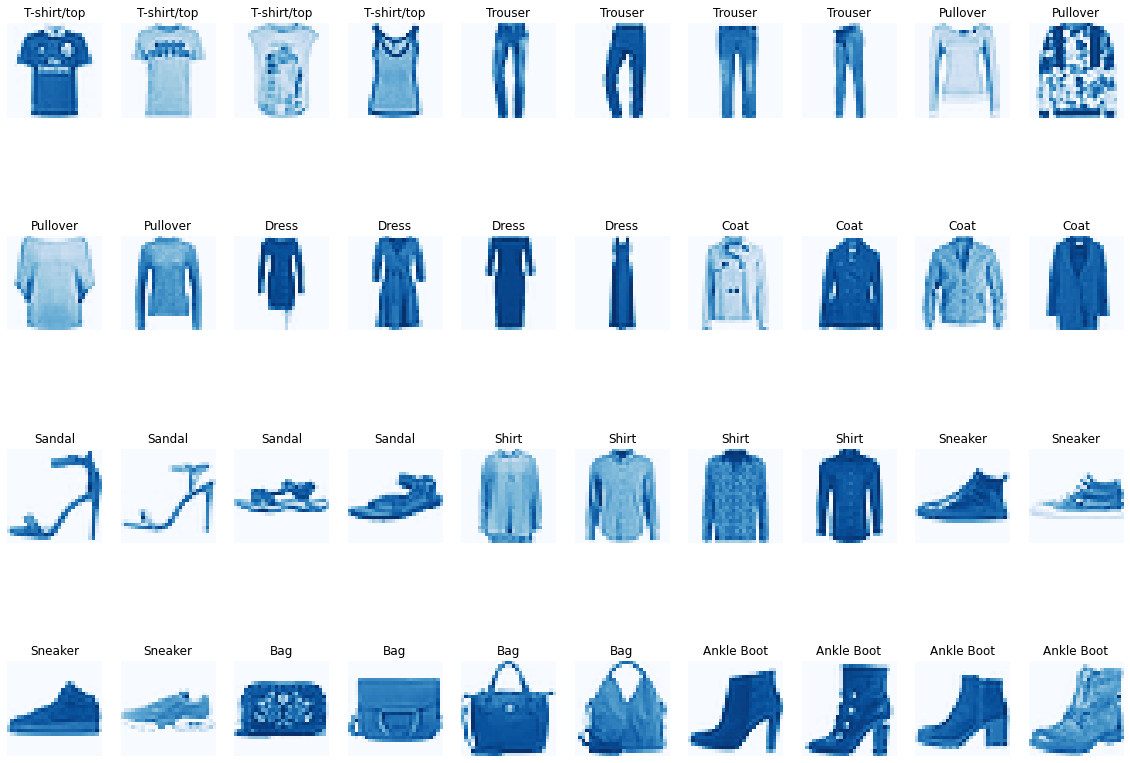

In [177]:
test_sample_images, test_sample_labels = sample_images_data(test_data)
plot_sample_images(test_sample_images,test_sample_labels)

In [178]:
# data preprocessing
def data_preprocessing(raw):
    out_y = keras.utils.to_categorical(raw.label, NUM_CLASSES)
    num_images = raw.shape[0]
    x_as_array = raw.values[:,1:]
    x_shaped_array = x_as_array.reshape(num_images, IMG_ROWS, IMG_COLS, 1)
    out_x = x_shaped_array / 255
    return out_x, out_y

In [179]:
# prepare the data
X, y = data_preprocessing(train_data)
X_test, y_test = data_preprocessing(test_data)

In [180]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [181]:
print("Fashion MNIST train -  rows:",X_train.shape[0]," columns:", X_train.shape[1:4])
print("Fashion MNIST valid -  rows:",X_val.shape[0]," columns:", X_val.shape[1:4])
print("Fashion MNIST test -  rows:",X_test.shape[0]," columns:", X_test.shape[1:4])
print(y_test.shape[1:4])

Fashion MNIST train -  rows: 48000  columns: (28, 28, 1)
Fashion MNIST valid -  rows: 12000  columns: (28, 28, 1)
Fashion MNIST test -  rows: 10000  columns: (28, 28, 1)
(10,)


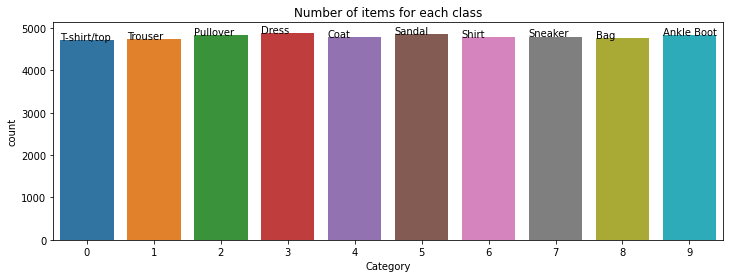

Dress               :   4891 or 10.189583333333333%
Sandal              :   4855 or 10.114583333333334%
Pullover            :   4836 or 10.075000000000001%
Ankle Boot          :   4827 or 10.05625%
Sneaker             :   4798 or 9.995833333333334%
Coat                :   4796 or 9.991666666666667%
Shirt               :   4779 or 9.95625%
Bag                 :   4757 or 9.910416666666666%
Trouser             :   4745 or 9.885416666666668%
T-shirt/top         :   4716 or 9.825000000000001%


In [182]:
def plot_count_per_class(yd):
    ydf = pd.DataFrame(yd)
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(ydf[0], order = np.arange(0,10))
    g.set_title("Number of items for each class")
    g.set_xlabel("Category")
    
    for p, label in zip(g.patches, np.arange(0,10)):
        g.annotate(labels[label], (p.get_x(), p.get_height()+0.1))
        
    plt.show()  

def get_count_per_class(yd):
    ydf = pd.DataFrame(yd)
    # Get the count for each label
    label_counts = ydf[0].value_counts()

    # Get total number of samples
    total_samples = len(yd)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))
    
plot_count_per_class(np.argmax(y_train,axis=1))
get_count_per_class(np.argmax(y_train,axis=1))

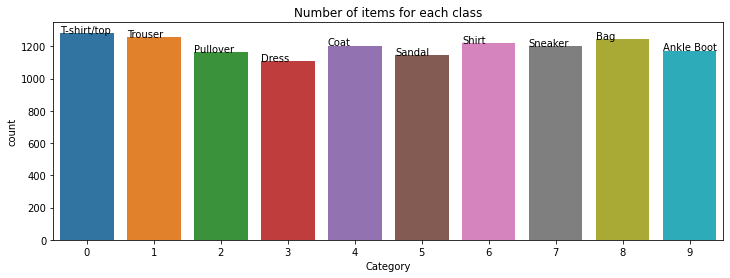

T-shirt/top         :   1284 or 10.7%
Trouser             :   1255 or 10.458333333333334%
Bag                 :   1243 or 10.358333333333333%
Shirt               :   1221 or 10.174999999999999%
Coat                :   1204 or 10.033333333333333%
Sneaker             :   1202 or 10.016666666666667%
Ankle Boot          :   1173 or 9.775%
Pullover            :   1164 or 9.700000000000001%
Sandal              :   1145 or 9.541666666666666%
Dress               :   1109 or 9.241666666666665%


In [183]:
plot_count_per_class(np.argmax(y_val,axis=1))
get_count_per_class(np.argmax(y_val,axis=1))

In [184]:
# Model
model = Sequential()
# Add convolution 2D
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(IMG_ROWS, IMG_COLS, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [155]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_19 (Flatten)         (None, 1152)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)             

In [156]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/15
375/375 [==============================] - 45s 119ms/step - loss: 0.5249 - accuracy: 0.8117 - val_loss: 0.3760 - val_accuracy: 0.8667
Epoch 2/15
375/375 [==============================] - 44s 118ms/step - loss: 0.3333 - accuracy: 0.8782 - val_loss: 0.3397 - val_accuracy: 0.8773
Epoch 3/15
375/375 [==============================] - 44s 119ms/step - loss: 0.2844 - accuracy: 0.8956 - val_loss: 0.2945 - val_accuracy: 0.8955
Epoch 4/15
375/375 [==============================] - 45s 119ms/step - loss: 0.2511 - accuracy: 0.9076 - val_loss: 0.2928 - val_accuracy: 0.8957
Epoch 5/15
375/375 [==============================] - 45s 120ms/step - loss: 0.2259 - accuracy: 0.9171 - val_loss: 0.2823 - val_accuracy: 0.8983
Epoch 6/15
375/375 [==============================] - 44s 119ms/step - loss: 0.2027 - accuracy: 0.9247 - val_loss: 0.2663 - val_accuracy: 0.9067
Epoch 7/15
375/375 [==============================] - 45s 119ms/step - loss: 0.1825 - accuracy: 0.9318 - val_loss: 0.2650 - val_ac

In [185]:
score = model.evaluate(X_test, y_test, verbose=0)
score_val = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print('Val loss:', score_val[0])
print('Val accuracy:', score_val[1])

Test loss: 2.3276498317718506
Test accuracy: 0.0803999975323677
Val loss: 2.3230350017547607
Val accuracy: 0.08058333396911621


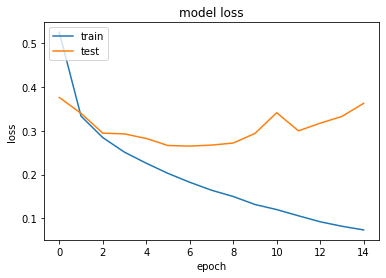

In [186]:
plt.plot(train_model.history["loss"])
plt.plot(train_model.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

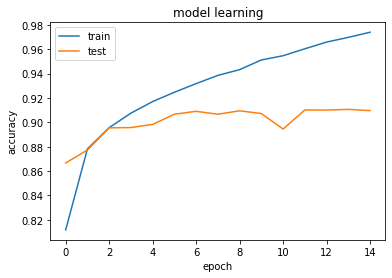

In [187]:
plt.plot(train_model.history["accuracy"])
plt.plot(train_model.history["val_accuracy"])
plt.title("model learning")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

In [188]:
# Model
model = Sequential()
# Add convolution 2D
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(IMG_ROWS, IMG_COLS, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [189]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 3, 3, 128)       

In [190]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/15
375/375 [==============================] - 49s 130ms/step - loss: 0.8148 - accuracy: 0.6969 - val_loss: 0.4882 - val_accuracy: 0.8117
Epoch 2/15
375/375 [==============================] - 48s 129ms/step - loss: 0.5152 - accuracy: 0.8116 - val_loss: 0.4097 - val_accuracy: 0.8467
Epoch 3/15
375/375 [==============================] - 49s 129ms/step - loss: 0.4420 - accuracy: 0.8389 - val_loss: 0.3510 - val_accuracy: 0.8719
Epoch 4/15
375/375 [==============================] - 47s 127ms/step - loss: 0.3935 - accuracy: 0.8575 - val_loss: 0.3180 - val_accuracy: 0.8841
Epoch 5/15
375/375 [==============================] - 48s 128ms/step - loss: 0.3675 - accuracy: 0.8671 - val_loss: 0.2951 - val_accuracy: 0.8910
Epoch 6/15
375/375 [==============================] - 48s 129ms/step - loss: 0.3436 - accuracy: 0.8746 - val_loss: 0.2860 - val_accuracy: 0.8943
Epoch 7/15
375/375 [==============================] - 48s 129ms/step - loss: 0.3334 - accuracy: 0.8787 - val_loss: 0.2732 - val_ac

In [191]:
score = model.evaluate(X_test,y_test, verbose=0)
score_val = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print('Val loss:', score_val[0])
print('Val accuracy:', score_val[1])

Test loss: 0.22501489520072937
Test accuracy: 0.911899983882904
Val loss: 0.2422945499420166
Val accuracy: 0.9114166498184204


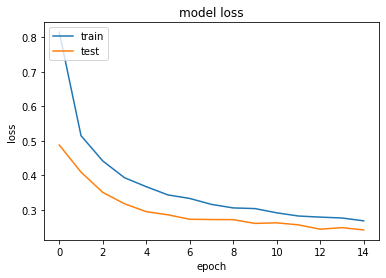

In [192]:
plt.plot(train_model.history["loss"])
plt.plot(train_model.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

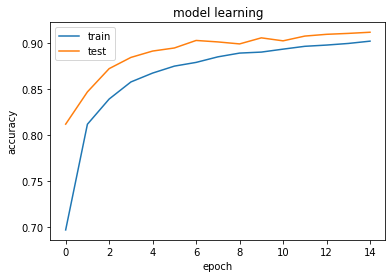

In [193]:
plt.plot(train_model.history["accuracy"])
plt.plot(train_model.history["val_accuracy"])
plt.title("model learning")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

In [194]:
# Model
model = Sequential()
# Add convolution 2D
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(IMG_ROWS, IMG_COLS, 1)))
model.add(BatchNormalization(axis = 1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))
model.add(BatchNormalization(axis = 1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization(axis = 1))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization(axis = 1))
model.add(Dropout(0.4))
model.add(Dense(NUM_CLASSES, activation='softmax'))


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [196]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_17 (Batc (None, 26, 26, 32)        104       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_18 (Batc (None, 11, 11, 64)        44        
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 5, 5, 64)        

In [197]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/15
375/375 [==============================] - 94s 250ms/step - loss: 0.7900 - accuracy: 0.7168 - val_loss: 0.4509 - val_accuracy: 0.8365
Epoch 2/15
375/375 [==============================] - 94s 251ms/step - loss: 0.4661 - accuracy: 0.8300 - val_loss: 0.3599 - val_accuracy: 0.8706
Epoch 3/15
375/375 [==============================] - 94s 251ms/step - loss: 0.4019 - accuracy: 0.8528 - val_loss: 0.3212 - val_accuracy: 0.8830
Epoch 4/15
375/375 [==============================] - 94s 252ms/step - loss: 0.3619 - accuracy: 0.8665 - val_loss: 0.2929 - val_accuracy: 0.8940
Epoch 5/15
375/375 [==============================] - 95s 252ms/step - loss: 0.3349 - accuracy: 0.8786 - val_loss: 0.2754 - val_accuracy: 0.8984
Epoch 6/15
375/375 [==============================] - 94s 251ms/step - loss: 0.3134 - accuracy: 0.8863 - val_loss: 0.2693 - val_accuracy: 0.9004
Epoch 7/15
375/375 [==============================] - 94s 252ms/step - loss: 0.3011 - accuracy: 0.8904 - val_loss: 0.2611 - val_ac

In [198]:
score = model.evaluate(X_test,y_test, verbose=0)
score_val = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print('Val loss:', score_val[0])
print('Val accuracy:', score_val[1])

Test loss: 0.21002931892871857
Test accuracy: 0.9199000000953674
Val loss: 0.22129406034946442
Val accuracy: 0.92208331823349


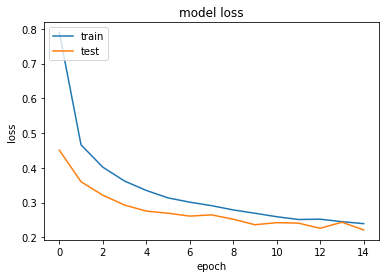

In [199]:
plt.plot(train_model.history["loss"])
plt.plot(train_model.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

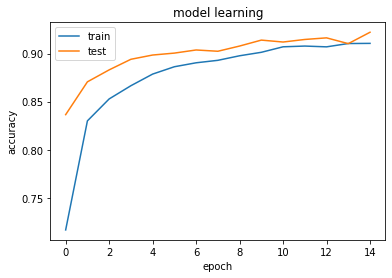

In [200]:
plt.plot(train_model.history["accuracy"])
plt.plot(train_model.history["val_accuracy"])
plt.title("model learning")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

In [201]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_test)
#get the indices to be plotted
y_true = test_data.iloc[:, 0]

In [202]:
p = predicted_classes[:9999]
y = y_true[:9999]
y_l=y.to_numpy()
correct = np.nonzero(p==y_l)[0]
incorrect = np.nonzero(p!=y_l)[0]

In [203]:
print("Correct predicted classes:",correct.shape)
print("Incorrect predicted classes:",incorrect.shape)
print("Prediction percentage %:",correct.shape[0]/9999)

Correct predicted classes: (9198,)
Incorrect predicted classes: (801,)
Prediction percentage %: 0.9198919891989199


In [204]:
target_names = ["Class {} ({}) :".format(i,labels[i]) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

                         precision    recall  f1-score   support

Class 0 (T-shirt/top) :       0.86      0.88      0.87      1000
    Class 1 (Trouser) :       0.99      0.99      0.99      1000
   Class 2 (Pullover) :       0.93      0.83      0.88      1000
      Class 3 (Dress) :       0.90      0.95      0.93      1000
       Class 4 (Coat) :       0.85      0.92      0.88      1000
     Class 5 (Sandal) :       0.99      0.97      0.98      1000
      Class 6 (Shirt) :       0.79      0.74      0.76      1000
    Class 7 (Sneaker) :       0.96      0.96      0.96      1000
        Class 8 (Bag) :       0.98      0.99      0.99      1000
 Class 9 (Ankle Boot) :       0.95      0.97      0.96      1000

               accuracy                           0.92     10000
              macro avg       0.92      0.92      0.92     10000
           weighted avg       0.92      0.92      0.92     10000



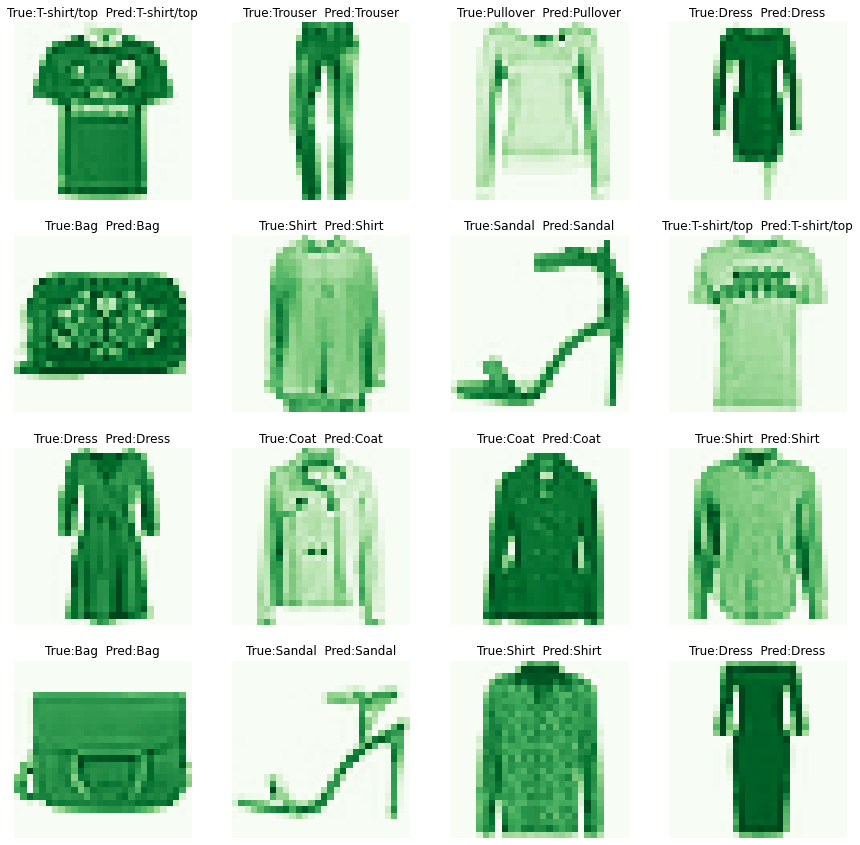

In [205]:
def plot_images(data_index,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(4,4, figsize=(15,15))

    for i, indx in enumerate(data_index[:16]):
        ax[i//4, i%4].imshow(X_test[indx].reshape(IMG_ROWS,IMG_COLS), cmap=cmap)
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title("True:{}  Pred:{}".format(labels[y_true[indx]],labels[predicted_classes[indx]]))
    plt.show()    
    
plot_images(correct, "Greens")

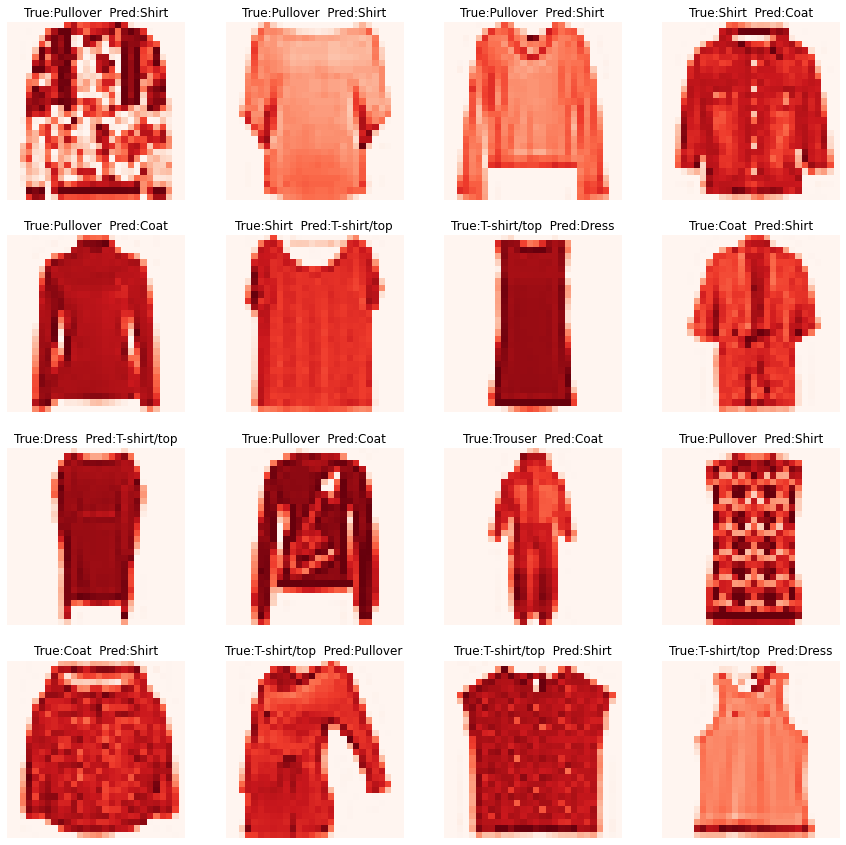

In [206]:
plot_images(incorrect, "Reds")